In [1]:
!pip install modAL

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import csv
import time
import pickle
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sn


import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

from modAL.models import ActiveLearner
from modAL.uncertainty import *
from modAL.batch import uncertainty_batch_sampling


import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [3]:
his_folder = "./his"
img_folder = "./img"
feed_folder = "./feed"
log_folder = "./log"
NP_SEED = 42

np.random.seed(NP_SEED)

In [ ]:
filePathName = './RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

In [4]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [5]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

dict_label_list = [k for k,v in sorted(dict_label.items(), key = lambda x: x[1])]
print(dict_label_list)

['numeric', 'categorical', 'datetime', 'sentence', 'url', 'embedded-number', 'list', 'not-generalizable', 'context-specific']


In [6]:
def ProcessStats(data,y):
    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')


def FeatureExtraction(data,data1,flag):
    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    #print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    #print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    #print(len(data2))
    return data2

In [7]:
def get_data(sim_size = 0.8):
    """
    sim_size is the % of training data that goes into simulation set.
    """
    xtrain = pd.read_csv('./data_train.csv')
    xtest = pd.read_csv('./data_test.csv')

    y_train = xtrain.loc[:,['y_act']]
    y_test = xtest.loc[:,['y_act']]
    y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
    y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]
    
    xtrain1 = ProcessStats(xtrain,y_train)
    xtest1 = ProcessStats(xtest,y_test)

    X_train = FeatureExtraction(xtrain,xtrain1,1)
    X_test = FeatureExtraction(xtest,xtest1,0)

    X_train_new = X_train.reset_index(drop=True)
    y_train_new = y_train.reset_index(drop=True)
    X_train_new = X_train_new.values
    y_train_new = y_train_new.values
    
    # setting up data
    X_train_AL, X_simulation_AL, y_train_AL, y_simulation_AL = train_test_split(X_train_new, y_train, test_size=sim_size, random_state=NP_SEED, stratify = y_train)
    # Start AL loops simulated with a part of the test data
    X_simulation_df = pd.DataFrame(X_simulation_AL)
    y_simulation_df = pd.DataFrame(y_simulation_AL)
    # making copies of existing X_test and y_test data
    X_test_df = pd.DataFrame(X_test)
    y_test_df = pd.DataFrame(y_test)
    
    assert len(X_train_AL) == len(y_train_AL)
    assert len(X_simulation_df) == len(y_simulation_df)
    assert len(X_test_df) == len(y_test_df)
    return X_train_AL, y_train_AL, X_simulation_df, y_simulation_df, X_test_df, y_test_df

X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
print(f"Training set size: {len(X_train)}, Simulation set size: {len(X_sim)}, Test set size: {len(X_test)}")

Training set size: 1587, Simulation set size: 6349, Test set size: 1985


In [8]:
print(X_train.shape, y_train.shape)
print(X_sim.shape, y_sim.shape)
print(X_test.shape, y_test.shape)

(1587, 1478) (1587, 1)
(6349, 1478) (6349, 1)
(1985, 1478) (1985, 1)


In [9]:
def grid_parameter_search(X_train, y_train, X_test, y_test, n_estimators_grid, max_depth_grid, query_size):
    best_model_score = 0
    
    preset_batch = partial(uncertainty_sampling, n_instances=query_size)
    
    for ne in n_estimators_grid:
        for md in max_depth_grid:
            learner = ActiveLearner(
                  estimator=RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=100),
                  X_training=X_train, y_training=y_train,
                  query_strategy=preset_batch
                )
            score = learner.score(X_test, y_test)
            print(f"[n_estimator: {ne}, max_depth: {md}, accuracy: {score}]")
            if best_model_score < score:
                best_ne = ne
                best_md = md
                best_model_score = score
                bestPerformingModel = learner
    print(f"Best model found at ne:{best_ne}, md:{best_md}, at score:{best_model_score}")
    return learner, best_ne, best_md, best_model_score

In [10]:
def save_his(data, full_path):
    assert data != None and len(data.items()) > 0, "data should not be empty"
    
    with open(full_path, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(list(data.keys()))
        writer.writerows(zip(*data.values()))
    

test_data_1 = [i for i in range(100)]
test_data_2 = [i*2 for i in range(100)]
test_data_3 = [i*3 for i in range(100)]
test_data_4 = [i*4 for i in range(100)]
data = {"num_queries": test_data_1, "time": test_data_2, "total_time":test_data_3, "test_accuracy":test_data_4}

save_his(data, his_folder + "/test.csv")

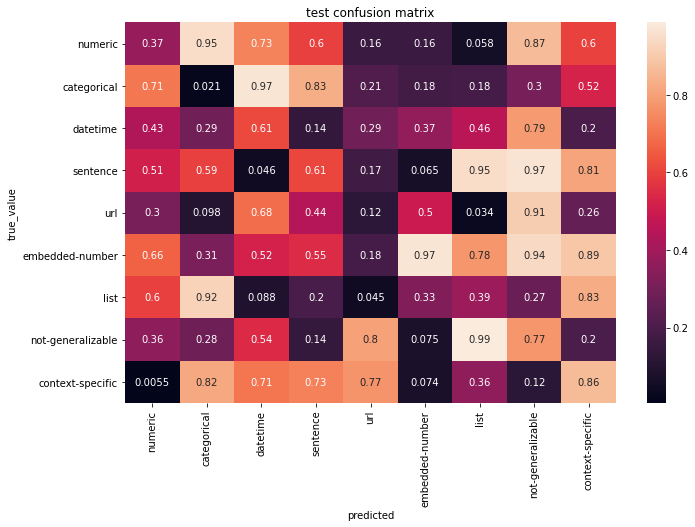

In [11]:
con_matrix = np.random.rand(9,9)
title = "test confusion matrix"

def save_con_matrix(con_matrix, title, full_path, show=False):
    plt.figure(figsize = (11,7))
    df_cm = pd.DataFrame(con_matrix, index = dict_label_list, columns = dict_label_list)
    sn.heatmap(con_matrix, annot=True, xticklabels=dict_label_list, yticklabels=dict_label_list, ) # font size

    plt.title(title) # title with fontsize 20
    plt.xlabel('predicted') # x-axis label with fontsize 15
    plt.ylabel('true_value') # y-axis label with fontsize 15

    plt.savefig(full_path)

save_con_matrix(con_matrix, title, img_folder + "/test_matrix.png")

In [12]:
test_feed = np.random.rand(9,9)

def save_feed(feed, full_path):
    file = open(full_path, 'wb')
    pickle.dump(feed, file)
    
def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

save_feed(test_feed, feed_folder + "/test.pkl")
re = load_feed(feed_folder + "/test.pkl")

assert np.all(test_feed == re)

In [13]:
def log(file_name, *x):
    line = ' '.join([str(a) for a in x])
    open(file_name, "a").write(line + '\n')
    print(line)

In [14]:
def train_this(n_est, max_dept, query_size, max_feed, per_iteration_acc_report = True, feed_his = None):
    console_log_name = f"./log/train_log_ne{n_est}_md{max_dept}_qs{query_size}.log"
    metrics_log_name = f"./log/metrics_log_ne{n_est}_md{max_dept}_qs{query_size}.log"
    console_log_file = open(console_log_name, "a")
    metrics_log_file = open(metrics_log_name, "a")
    
    # getting data
    X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
    
    # get learner
    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(\
    estimator=RandomForestClassifier(n_estimators=n_est, max_depth=max_dept, random_state=100),
        X_training=X_train, y_training=y_train,
        query_strategy=preset_batch
        )
    
    # init tracker lists
    num_queries = [0]
    time_history = [0]
    total_time_history = [0]
    train_acc_history = [learner.score(X_train, y_train)]
    sim_acc_history = [learner.score(X_sim, y_sim)]
    test_acc_history = [learner.score(X_test, y_test)]
    feed_to_learner = []
    
    log(console_log_name, f"learner trained_acc:{train_acc_history}, sim_acc:{sim_acc_history}, test_acc:{test_acc_history}")
    
    # AL cycle
    t_start = time.time()

    X_train_df = pd.DataFrame(X_train)
    y_train_df = pd.DataFrame(y_train)
    
    while len(feed_to_learner) * query_size < max_feed :
        current_count = len(feed_to_learner) * query_size
        log(console_log_name, f"\n*********** QUERY {current_count} *********** remain:{len(X_sim)}")
        t0 = time.time()
        
        #AL selection
        query_idx = []
        
        if feed_his:
            query_idx = feed_his[0]
            feed_his = feed_his[1:]
        else:
            query_idx, _ = learner.query(np.array(X_sim))
            if current_count + len(query_idx) > max_feed:
                query_idx = query_idx[:current_count + len(query_idx) - max_feed]
                #query_inst = query_inst[:current_count + len(query_idx) - max_feed] 
            
        log(console_log_name, f"Nodes returned for query in query {current_count}: {query_idx}")

        #updating learner
        learner.teach(X = X_sim.iloc[query_idx], y = y_sim.iloc[query_idx])
        feed_to_learner.append(list(query_idx))

        # updating train set to calculate accuracy
        X_train_df = X_train_df.append(X_sim.iloc[query_idx])
        y_train_df = y_train_df.append(y_sim.iloc[query_idx])
        
        # dropping queried entries from sim set
        X_sim = X_sim.drop(X_sim.index[query_idx])
        y_sim = y_sim.drop(y_sim.index[query_idx])
        
        # recording history
        t1 = time.time()
        time_history.append(t1 - t0)
        total_time_elapsed = t1 - t_start
        num_queries.append(len(feed_to_learner)* query_size)

        # Calculate and report our model's accuracy.
        if per_iteration_acc_report:
            test_acc = learner.score(X_test, y_test)
            sim_acc = learner.score(X_sim, y_sim)
            print(len(X_train_df), len(y_train_df))
            train_acc = learner.score(X_train, y_train)
                
            test_acc_history.append(  test_acc  )
            sim_acc_history.append(   sim_acc   )
            train_acc_history.append( train_acc )
            log(console_log_name, f"\n[INTERMEDIATE] test_acc:{test_acc}, sim_acc:{sim_acc}, train_acc:{train_acc}")
            
        log(console_log_name, f"\n[INTERMEDIATE] Time taken for query {current_count}: {time_history[-1]}")
        log(console_log_name, f"\n[INTERMEDIATE] Total time taken {current_count}: {total_time_elapsed}")

        log(metrics_log_name, f"\nQuery {current_count}\n\nQuery_nodes={query_idx}\nSimulation_accuracy={sim_acc}\nTest_accuracy={test_acc}\nTrain_accuracy={train_acc}\nQuery_time={time_history[-1]}\nTime_elapsed={total_time_elapsed}")

    # saving data into csv
    log(console_log_name, f"Saving data for for ne={n_est}, md={max_dept}, qs={query_size}")
    
    al_sampling = "Uncertainty_Batch_Sampling"
    file_name = f"{al_sampling}_ne{n_est}_dept{max_dept}_query{query_size}"
    
    data = {"num_queries": num_queries, "time": time_history, "total_time":total_time_history,\
            #"train_accuracy":train_acc_history, \
            "simulation_accuracy":sim_acc_history,\
            "test_accuracy":test_acc_history}
    save_his(data, f"{his_folder}/{file_name}.csv")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"AL using decision tree classifier (n_est = {n_est}, max_dept = {max_dept}) with {al_sampling} (query_size = {query_size})"
    save_con_matrix(con_matrix, title, f"{img_folder}/{file_name}.png")
    
    # saving feed into pickle
    save_feed(feed_to_learner, f"{feed_folder}/{file_name}.pkl")
        
    log(console_log_name, f"Completed for ne={n_est}, md={max_dept}, qs={query_size}")
    metrics_log_file.close()
    console_log_file.close()

[n_estimator: 100, max_depth: 100, accuracy: 0.8862813041423846]
[n_estimator: 100, max_depth: 200, accuracy: 0.8862813041423846]
[n_estimator: 100, max_depth: 300, accuracy: 0.8862813041423846]
[n_estimator: 100, max_depth: 400, accuracy: 0.8862813041423846]
[n_estimator: 200, max_depth: 100, accuracy: 0.8883288706882974]
[n_estimator: 200, max_depth: 200, accuracy: 0.8883288706882974]
[n_estimator: 200, max_depth: 300, accuracy: 0.8883288706882974]
[n_estimator: 200, max_depth: 400, accuracy: 0.8883288706882974]
[n_estimator: 300, max_depth: 100, accuracy: 0.8895889116396283]
[n_estimator: 300, max_depth: 200, accuracy: 0.8895889116396283]
[n_estimator: 300, max_depth: 300, accuracy: 0.8895889116396283]
[n_estimator: 300, max_depth: 400, accuracy: 0.8895889116396283]
[n_estimator: 400, max_depth: 100, accuracy: 0.8902189321152938]
[n_estimator: 400, max_depth: 200, accuracy: 0.8902189321152938]
[n_estimator: 400, max_depth: 300, accuracy: 0.8902189321152938]
[n_estimator: 400, max_de

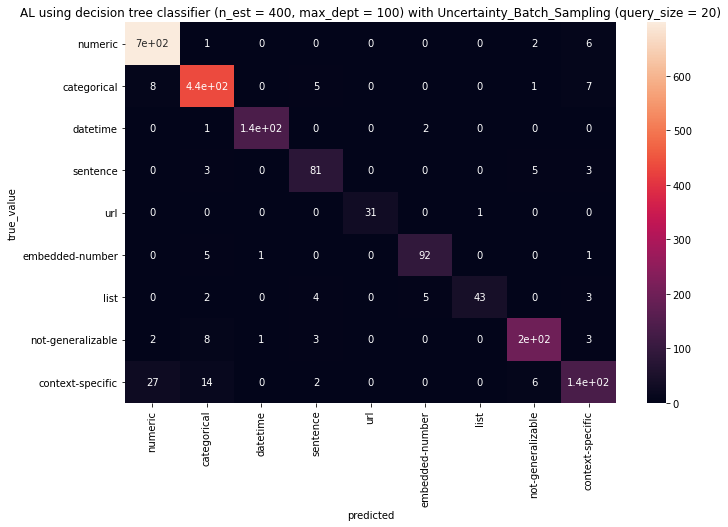

In [16]:
with warnings.catch_warnings(record="True"):       
    for qs in [20]:
        feed_his = None
        learner, best_ne, best_md, best_model_score = grid_parameter_search(X_train, y_train, X_sim, y_sim, [i*100 for i in range(1, 5)],[i*100 for i in range(1, 5)], qs)
        print(f"[BEST OBTAINED RF ESTIMATOR] === [n_estimator: {best_ne}, max_depth: {best_md}, accuracy: {best_model_score}]")
        try:
            file_name = f"Uncertainty_Batch_Sampling_ne{best_ne}_dept{best_md}_query{qs}"
            feed_his = load_feed(f"{feed_folder}/{file_name}.pkl")
        except:
            print(f"feed history for qs {qs} not found, starting fresh")
        train_this(n_est=best_ne, max_dept=best_md, query_size=qs, max_feed = 6340, feed_his=feed_his)

dict_keys(['filename', 'num_queries', 'time', 'total_time', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'simulation_accuracy', 'test_accuracy'])


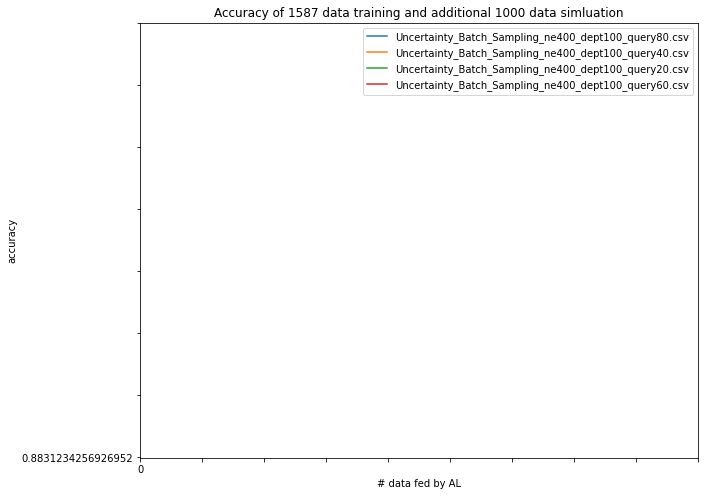

In [5]:
files = os.listdir(his_folder)

def get_results():
    for f in files:
        if f.endswith(".csv") and not f.startswith("test"):
            with open(f"{his_folder}/{f}", mode='r') as infile:
                reader = csv.reader(infile)
                temp = zip(*reader)

                results = {"filename": f}
                for i in temp:
                    results[i[0]] = i[1:]
                yield results

plt.figure(figsize=(10,8))
for r in get_results():
    print(r.keys())
    plt.plot(r["num_queries"], r["test_accuracy"], label = r["filename"])
    
plt.title("Accuracy of 1587 data training and additional 6340 data simluation")
plt.xlabel("# data fed by AL")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 100, 10))
plt.yticks(np.arange(0, 80, 10))
plt.legend()
plt.show()

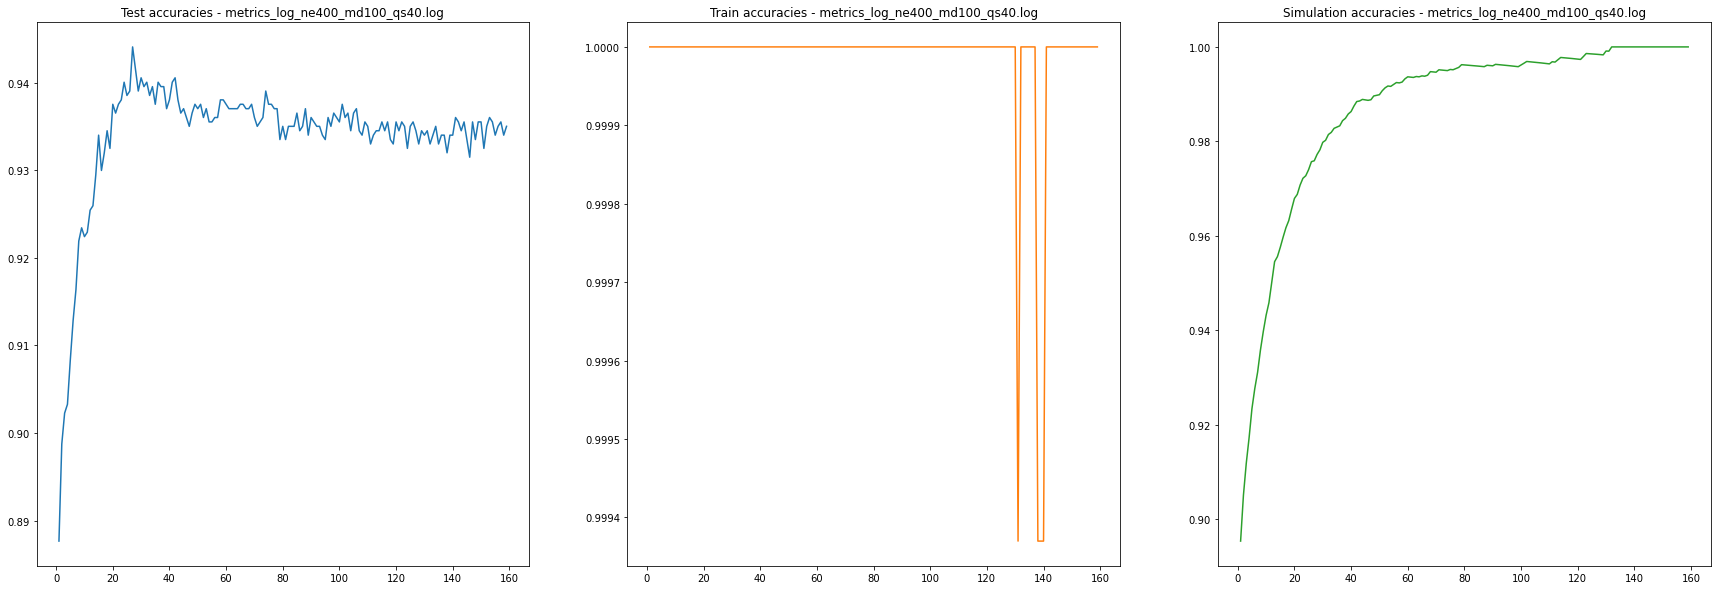

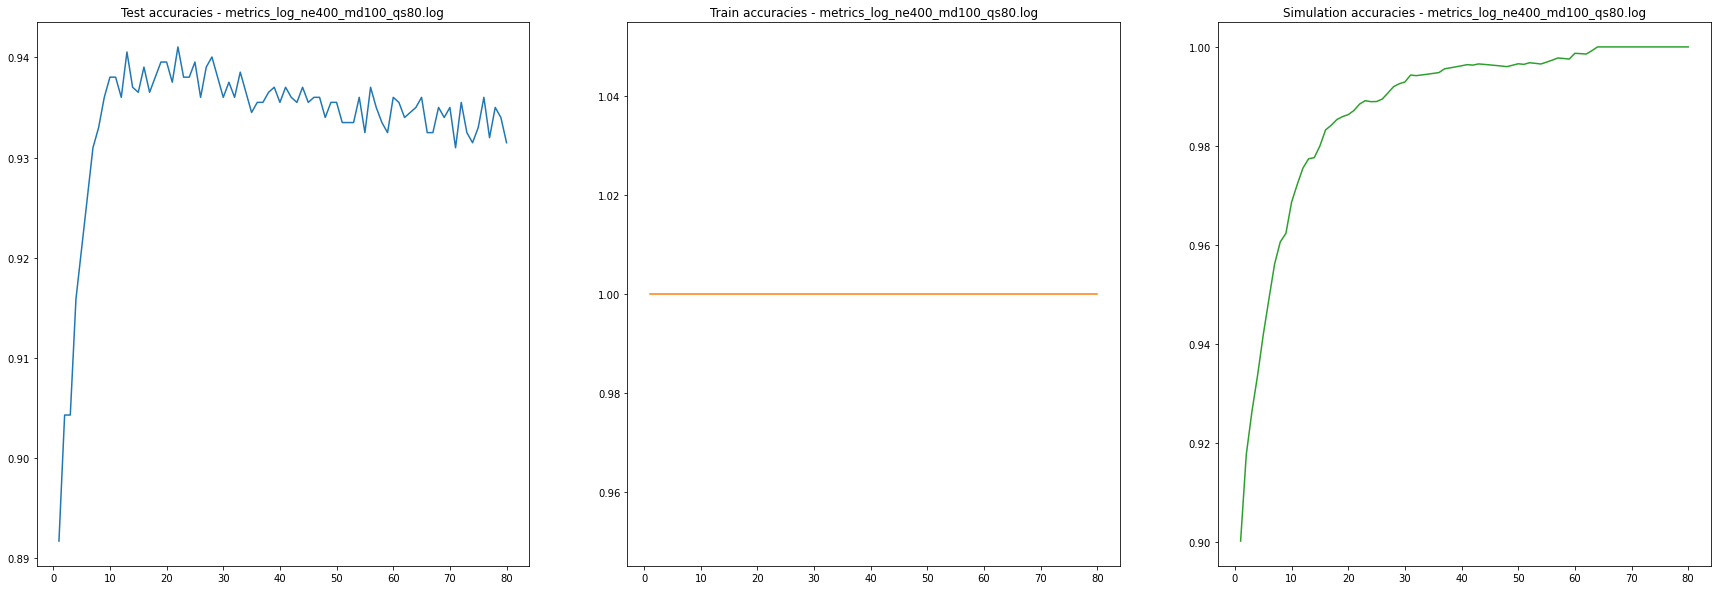

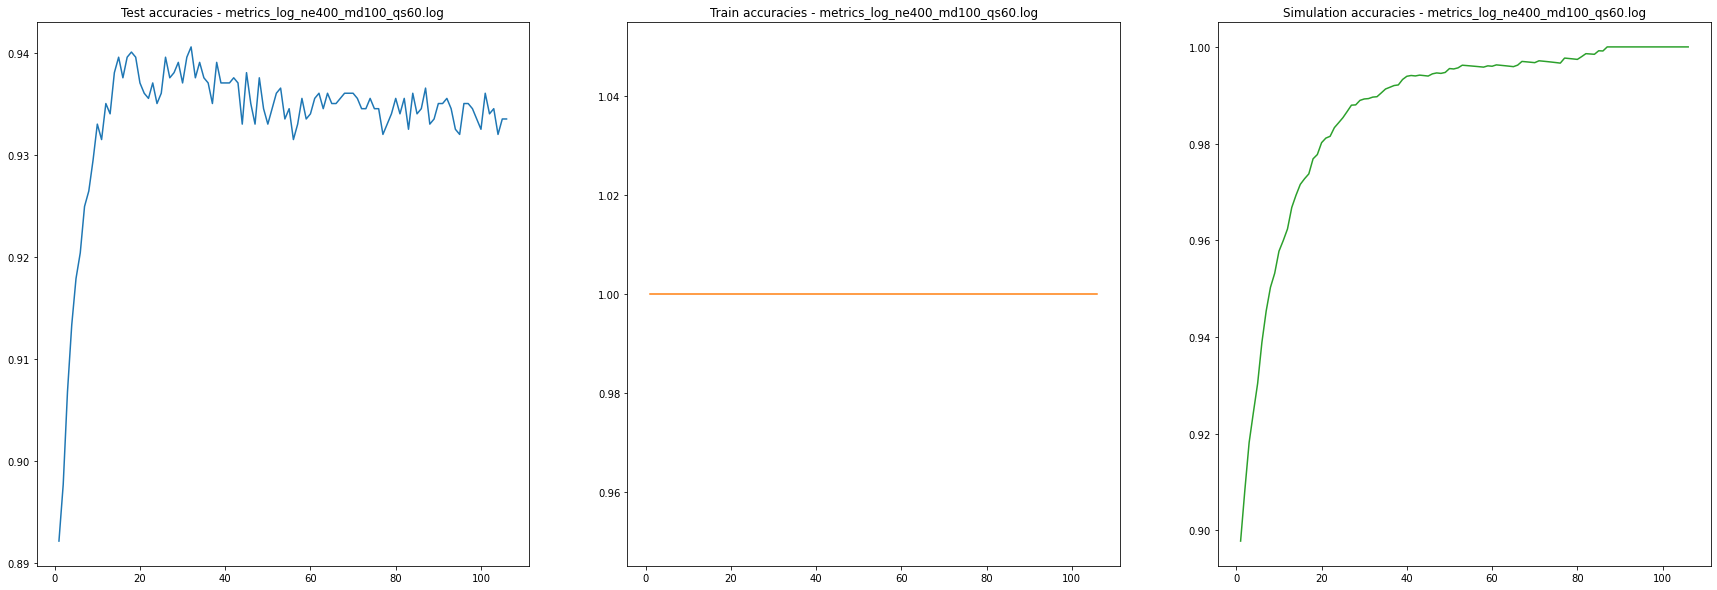

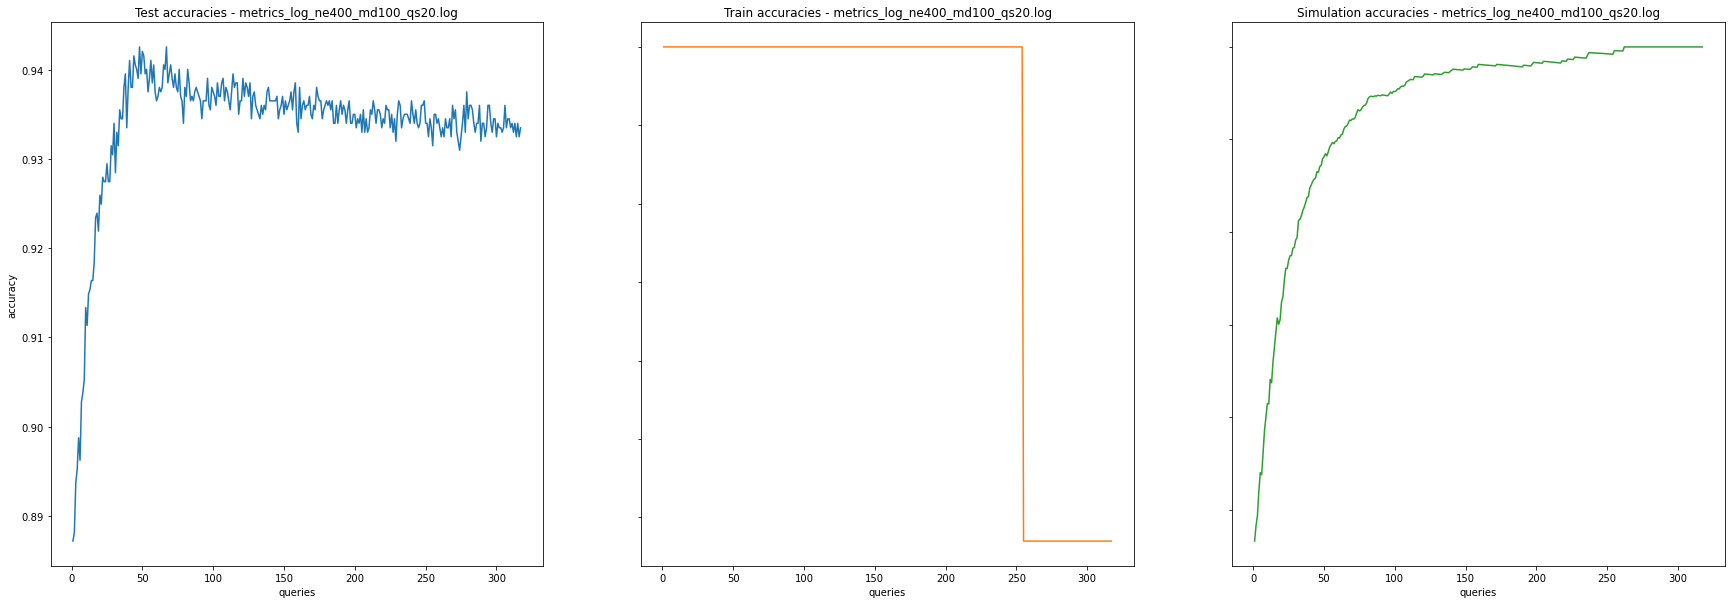

In [22]:
# read log files and plot 
files = os.listdir(log_folder)
query_time_dict = {}

for f in files:
    if f.startswith("metrics"):
        test_acc = []
        train_acc = []
        sim_acc = []
        query_times = []
        with open(f"{log_folder}/{f}", "r") as file:
            for line in file:
                if "Simulation_accuracy" in line:
                    sim_acc.append(float(line.split("=")[1]))
                elif "Train_accuracy" in line:
                    train_acc.append(float(line.split("=")[1]))
                elif "Test_accuracy" in line:
                    test_acc.append(float(line.split("=")[1]))
                elif "Query_time" in line:
                    query_times.append(float(line.split("=")[1]))
        
        x = [i for i in range(1, len(query_times) + 1)]
        
        fig, axs = plt.subplots(1, 3, figsize=(30,10))
        axs[0].plot(x, test_acc)
        axs[0].set_title('Test accuracies - ' + str(f))
        axs[1].plot(x, train_acc, 'tab:orange', label=f)
        axs[1].set_title('Train accuracies - ' + str(f))
        axs[2].plot(x, sim_acc, 'tab:green', label=f)
        axs[2].set_title('Simulation accuracies - ' + str(f))
        query_time_dict[f] = query_times
        
#         print(f, len(sim_acc), len(train_acc), len(query_times), len(test_acc))

for ax in axs.flat:
    ax.set(xlabel='queries', ylabel='accuracy')

for ax in axs.flat:
    ax.label_outer()
    
plt.show()

metrics_log_ne400_md100_qs40.log ====> Total time = 18326.39s & Average time per query = 115.26s
metrics_log_ne400_md100_qs80.log ====> Total time = 18842.07s & Average time per query = 235.53s
metrics_log_ne400_md100_qs60.log ====> Total time = 15705.24s & Average time per query = 148.16s
metrics_log_ne400_md100_qs20.log ====> Total time = 15877.97s & Average time per query = 50.09s


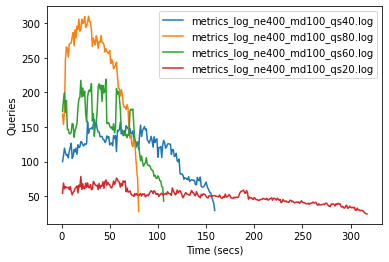

In [32]:
for k, v in query_time_dict.items():
    plt.plot([i for i in range(1, len(v) + 1)], v, label = k)
    print(f"{k} ====> Total time = {round(sum(v), 2)}s & Average time per query = {round(sum(v) / len(v), 2)}s")
plt.xlabel("Time (secs)")
plt.ylabel("Queries")
plt.legend()
plt.show()